<a href="https://colab.research.google.com/github/BaoGiang-Tran/ARIMA---TESLA-Stock/blob/main/ARIMA_models_TESLA_Stock's_price_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the libraries
!pip install --upgrade statsmodels
!pip install backtrader
!pip install pmdarima
!pip install arch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 5.2 MB/s eta 0:00:00


# **EDA - Explore Data Analysis**

In [ ]:
# Download the data
df = yf.download('TSLA',
                 start = '2013-01-01',
                 end = '2023-12-31',
                 progress = False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000
2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000
2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000
2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000
2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000


In [ ]:
# Infor of Data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2013-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2768 non-null   float64
 1   High       2768 non-null   float64
 2   Low        2768 non-null   float64
 3   Close      2768 non-null   float64
 4   Adj Close  2768 non-null   float64
 5   Volume     2768 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 151.4 KB


In [ ]:
# describle data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2.768000e+03
mean,86.165479,88.065652,84.119394,86.141737,86.141737,1.143746e+08
std,106.528592,108.908422,103.903977,106.440132,106.440132,7.812510e+07
min,2.205333,2.225333,2.140667,2.194000,2.194000,6.603000e+06
25%,14.829500,15.051000,14.598000,14.816833,14.816833,6.547125e+07
50%,20.492666,20.895334,20.111667,20.569000,20.569000,9.411275e+07
75%,184.712498,188.559166,180.440002,185.014999,185.014999,1.358409e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [ ]:
# Modify column name
df.rename(columns={'Adj Close':'adj_close'}, inplace = True)
# Convert adjusted close prices to simple and log returns

df['simple_rtn'] = df.adj_close.pct_change() #the simple return of a portfolio is the weighted sum of the returns of the individua assets in the porfolio.

df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1)) #the log return for a given month is the sum of the log returns of the days within that month.

#The diffrence between simple and log returs for daily/intraday data will be very small.
# the generaal rule is that log returns are smaller in value than simple returns.
df.head()

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000,NaN,NaN
2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000,-0.016685,-0.016826
2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000,-0.010642,-0.010699
2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000,-0.001744,-0.001746
2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000,-0.019220,-0.019407


#**Chapter 1** - **Financial Data and Preprocessing**



##**GARCH (Generalized Autoregressive Conditional Heteroskedasticity)**

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) is a model used to estimate future volatility based on past volatility, while realized volatility is a measure of actual volatility observed in historical data. GARCH models consider the conditional variance of the data, whereas realized volatility focuses on the actual volatility observed over a specific period.

In [ ]:
# Define the function for calculating the realized volatility
def realized_volatility(x):
  return np.sqrt(np.sum(x**2))


In [ ]:
# Keep only the adjusted close price
df1 = df.loc[:,['log_rtn']]

# Cal monthly realized volitility
df_rv = df1.groupby(pd.Grouper(freq="M")).apply(realized_volatility)
df_rv.rename(columns={'log_rtn':'rv'}, inplace = True)
df_rv.head()

,rv
Date,
2013-01-31,0.065365
2013-02-28,0.138970
2013-03-31,0.098149
2013-04-30,0.213774
2013-05-31,0.360679


In [ ]:
#Annualize the values
df_rv.rv = df_rv.rv * np.sqrt(12)

df_rv.head()

,rv
Date,
2013-01-31,0.226432
2013-02-28,0.481405
2013-03-31,0.339998
2013-04-30,0.740533
2013-05-31,1.249428


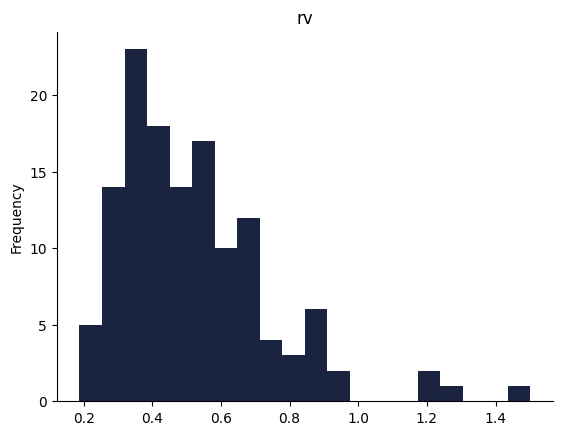

In [ ]:
# @title rv

from matplotlib import pyplot as plt
df_rv['rv'].plot(kind='hist', bins=20, title='rv')
plt.gca().spines[['top', 'right',]].set_visible(False)

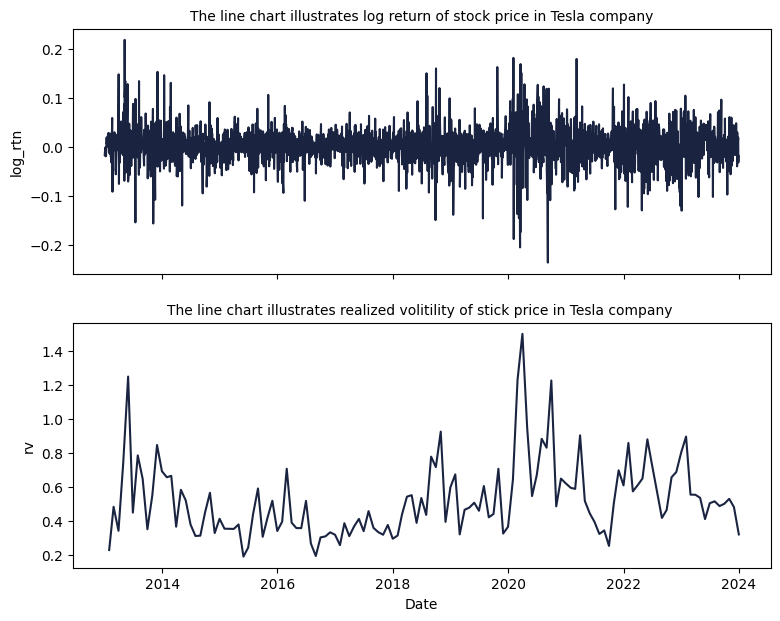

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1, figsize = (9,7), sharex = True)
sns.lineplot(df1['log_rtn'], ax = ax1).set_title('The line chart illustrates log return of stock price in Tesla company', size = 10)
sns.lineplot(df_rv['rv'], ax = ax2).set_title('The line chart illustrates realized volitility of stick price in Tesla company ', size = 10)
plt.show()

In the chart, the log return appears positive for most of the period, which suggests that the stock price increased over time. There are also some periods where the log return is negative, which indicates that the stock price decreased during those times.

The realized volatility appears to be higher in some periods than others. This suggests that the stock price was more volatile during those times.



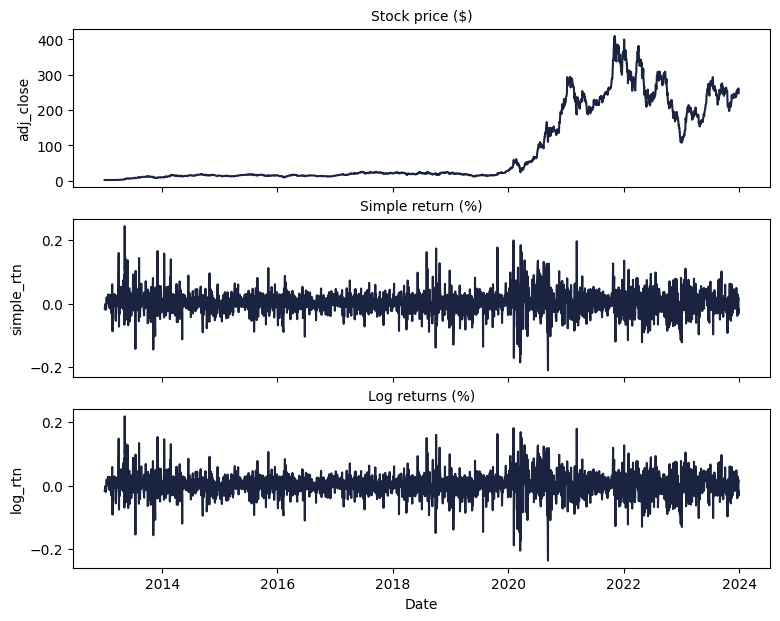

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (9,7), sharex = True)
sns.lineplot(df['adj_close'], ax = ax1). set_title('Stock price ($)', size = 10)
sns.lineplot(df['simple_rtn'], ax = ax2).set_title('Simple return (%)', size = 10)
sns.lineplot(df['log_rtn'], ax = ax3).set_title('Log returns (%)', size = 10)

plt.show()

In [ ]:
# Calculated the rolling mean and standard deviation
df_rolling = df[['simple_rtn']].rolling(window = 21).agg(['mean',
                                                          'std'])
df_rolling.columns = df_rolling.columns.droplevel()
df_rolling.tail()

,mean,std
Date,,
2023-12-22,0.003800,0.020859
2023-12-26,0.004315,0.021031
2023-12-27,0.005084,0.021262
2023-12-28,0.001433,0.020625
2023-12-29,0.001047,0.020932


In [ ]:
# Join the rolling metrics to the original data
df_outliers = df.join(df_rolling)

df_outliers.head(15)

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn,mean,std
Date,,,,,,,,,,
2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000,NaN,NaN,NaN,NaN
2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000,-0.016685,-0.016826,NaN,NaN
2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000,-0.010642,-0.010699,NaN,NaN
2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000,-0.001744,-0.001746,NaN,NaN
2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000,-0.019220,-0.019407,NaN,NaN
2013-01-09,2.267333,2.279333,2.226667,2.242667,2.242667,10470000,-0.001187,-0.001188,NaN,NaN
2013-01-10,2.258000,2.266000,2.225333,2.235333,2.235333,13837500,-0.003270,-0.003276,NaN,NaN
2013-01-11,2.269333,2.269333,2.140667,2.194000,2.194000,23448000,-0.018491,-0.018664,NaN,NaN
2013-01-14,2.205333,2.225333,2.190000,2.217333,2.217333,13876500,0.010635,0.010579,NaN,NaN


In [ ]:
df_outliers.tail(15)

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn,mean,std
Date,,,,,,,,,,
2023-12-08,240.270004,245.270004,239.270004,243.839996,243.839996,102980100,0.004946,0.004933,0.004811,0.027389
2023-12-11,242.740005,243.440002,237.449997,239.740005,239.740005,97913900,-0.016814,-0.016957,0.006611,0.024363
2023-12-12,238.550003,238.990005,233.869995,237.009995,237.009995,95328300,-0.011387,-0.011453,0.005010,0.024389
2023-12-13,234.190002,240.300003,228.199997,239.289993,239.289993,146286300,0.009620,0.009574,0.003458,0.022895
2023-12-14,241.220001,253.880005,240.789993,251.050003,251.050003,160829200,0.049145,0.047976,0.002882,0.021477
2023-12-15,251.210007,254.130005,248.300003,253.500000,253.500000,135720800,0.009759,0.009712,0.002257,0.021053
2023-12-18,253.779999,258.739990,251.360001,252.080002,252.080002,116416500,-0.005602,-0.005617,0.003804,0.019037
2023-12-19,253.479996,258.339996,253.009995,257.220001,257.220001,106737400,0.020390,0.020185,0.004631,0.019376
2023-12-20,256.410004,259.839996,247.000000,247.139999,247.139999,125097000,-0.039188,-0.039977,0.002500,0.021602


In [ ]:
# Define a function for detecting outliers
def indentify_outliers(row, n_sigmas = 3):
  x = row['simple_rtn']
  mu = row['mean']
  sigma = row['std']

  if (x > mu + n_sigmas * sigma) | (x < mu - n_sigmas *sigma):
    return 1
  else:
    return 0

In [ ]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2013-01-02 to 2023-12-29
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2768 non-null   float64
 1   High        2768 non-null   float64
 2   Low         2768 non-null   float64
 3   Close       2768 non-null   float64
 4   adj_close   2768 non-null   float64
 5   Volume      2768 non-null   int64  
 6   simple_rtn  2767 non-null   float64
 7   log_rtn     2767 non-null   float64
 8   mean        2747 non-null   float64
 9   std         2747 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 237.9 KB


In [ ]:
df_outliers.rename(columns = {'(simple_rtn, mean)':'mean',
                              '(simple_rtn, std)':'std'}, inplace =True)

In [ ]:

#Identify the putliers and extract their calues for lates use

df_outliers['outliers'] = df_outliers.apply(indentify_outliers, axis = 1)

outliers = df_outliers.loc[df_outliers['outliers'] == 1, ['simple_rtn']]

outliers

,simple_rtn
Date,
2013-04-01,0.159409
2013-05-09,0.243951
2013-07-16,-0.143093
2013-11-06,-0.145071
2014-01-14,0.157385
2014-06-16,0.088121
2014-09-15,-0.090759
2015-11-04,0.111735
2016-06-22,-0.104503


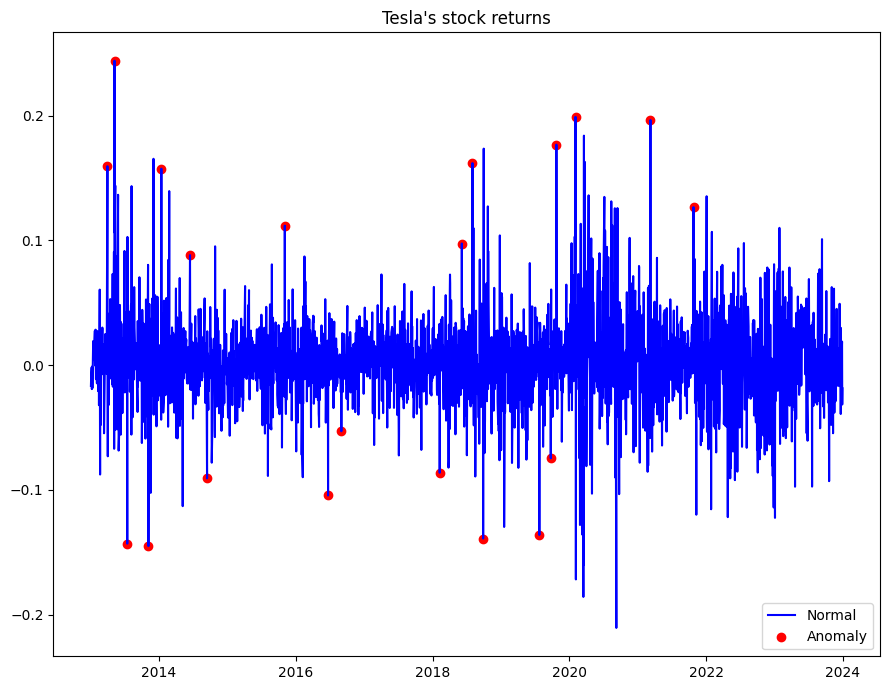

In [ ]:
f, ax = plt.subplots(figsize = (9,7))
ax.plot(df_outliers.index, df_outliers.simple_rtn,
        color = 'b', label = 'Normal')

ax.scatter(outliers.index, outliers.simple_rtn,
           color = 'red', label = 'Anomaly')

ax.set_title("Tesla's stock returns")
ax.legend(loc = "lower right")
plt.tight_layout()
plt.show()

##**Investigating stylized facts of asset returns**

In [ ]:
df.head(15)

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000,NaN,NaN
2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000,-0.016685,-0.016826
2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000,-0.010642,-0.010699
2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000,-0.001744,-0.001746
2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000,-0.019220,-0.019407
2013-01-09,2.267333,2.279333,2.226667,2.242667,2.242667,10470000,-0.001187,-0.001188
2013-01-10,2.258000,2.266000,2.225333,2.235333,2.235333,13837500,-0.003270,-0.003276
2013-01-11,2.269333,2.269333,2.140667,2.194000,2.194000,23448000,-0.018491,-0.018664
2013-01-14,2.205333,2.225333,2.190000,2.217333,2.217333,13876500,0.010635,0.010579


In [ ]:
#drop na
df2 = df[['adj_close','log_rtn']].dropna(how = 'any')

In [ ]:
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt


###**Fact 1 - Non-Gaussian distribution of returns**

In [ ]:
# Calculate the Normal PDF using the mean and STD of the observed returns
r_range = np.linspace(min(df.log_rtn), max(df2.log_rtn), num = 1000)
mu = df2.log_rtn.mean()
sigma = df2.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale = sigma)

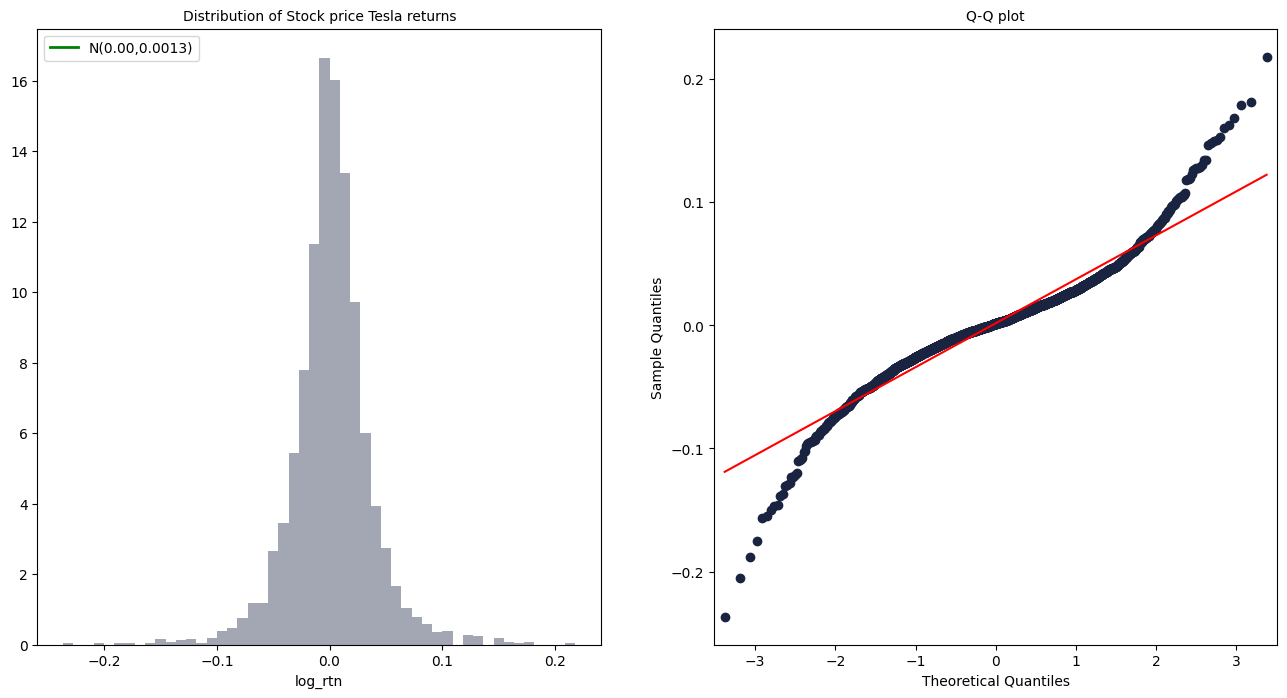

In [ ]:
f, ax = plt.subplots(1,2, figsize = (16,8))

# Histogram
sns.distplot(df2.log_rtn, kde = False, norm_hist=True, ax = ax[0])
ax[0].set_title('Distribution of Stock price Tesla returns', fontsize = 10)
ax[0].plot(r_range, norm_pdf, 'g', lw = 2,
           label = f'N({mu:.2f},{sigma**2:.4f})')
ax[0].legend(loc='upper left')

#Q-Q plot
qq = sm.qqplot(df2.log_rtn.values, line='s', ax = ax[1])
ax[1].set_title('Q-Q plot', fontsize = 10)

plt.show()

In [ ]:
#print the summary statistics of the log returns
jb_test = scs.jarque_bera(df2.log_rtn.values)

print('---------------- Descriptive Statistics ----------------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number os observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():4f}')
print(f'Median: { df.log_rtn.median():.4f}')
print(f'Min:{df.log_rtn.min():.4f}')
print(f'Max:{df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness:{df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}')
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------------- Descriptive Statistics ----------------
Range of dates: 2013-01-02 - 2023-12-29
Number os observations: 2768
Mean: 0.001683
Median: 0.0014
Min:-0.2365
Max:0.2183
Standard Deviation: 0.0357
Skewness:-0.0085
Kurtosis: 4.7693
Jarque-Bera statistic: 2610.65 with p-value: 0.00


- Mean (0.001683): The average daily log return is slightly positive, implying a long-term upward trend in price.

- Median (0.0014): The "typical" daily log return is even closer to zero, suggesting that small price movements are common.

- Minimum (-0.2365): The largest daily loss was around 23.65%.

- Maximum (0.2183): The largest daily gain was around 21.83%.

- Standard Deviation (0.0357): This measures the volatility, indicating daily log returns deviate from the mean by an average of 3.57%.

- Skewness (-0.0085): This value is close to zero, implying a very slight positive skew.

- Kurtosis (4.7693): This value exceeds 3 (normal distribution) indicating "fatter tails" compared to a normal distribution. This suggests larger than expected occurrences of both significant gains and losses compared to a normal distribution.

**Confirmation of non-normality:**

Jarque-Bera statistic (2610.65) and p-value (0.00): Both indicate a very low probability (essentially zero) that the data comes from a normal distribution.

###**Fact 2 - Volatility Clustering**

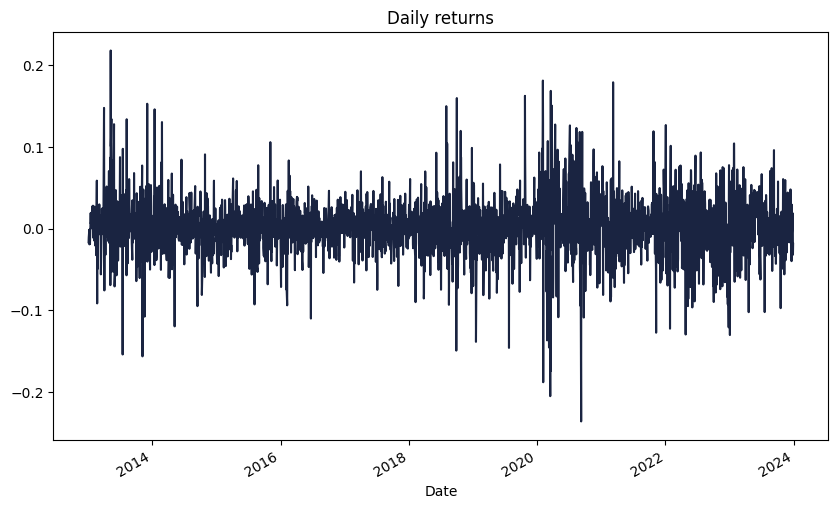

In [ ]:
# Run the following code to visualize the log returns series
df2.log_rtn.plot(title = 'Daily returns', figsize = (10,6))
plt.show()

###**Fact 3 - Absence of autocorrelation in returns**

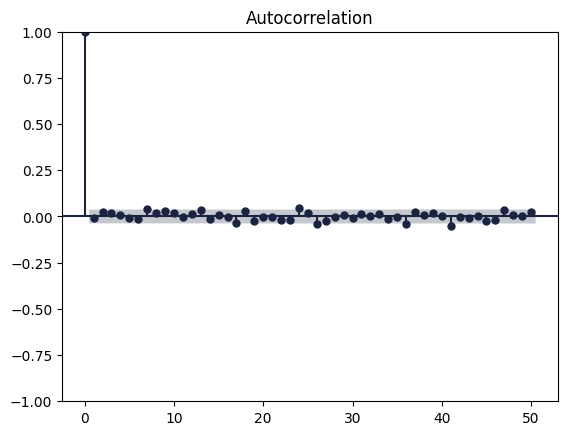

In [ ]:
# define the parameter for creating the Autocorreclation plots

N_LAGS = 50
significance_level = 0.05

# run the following code to create ACF plot of log returns

acf = smt.graphics.plot_acf(df2.log_rtn,
                            lags = N_LAGS,
                            alpha = significance_level)

plt.show()

###**Fact 4 - Small and decreasing autocorrelation in squared/absolute returns**

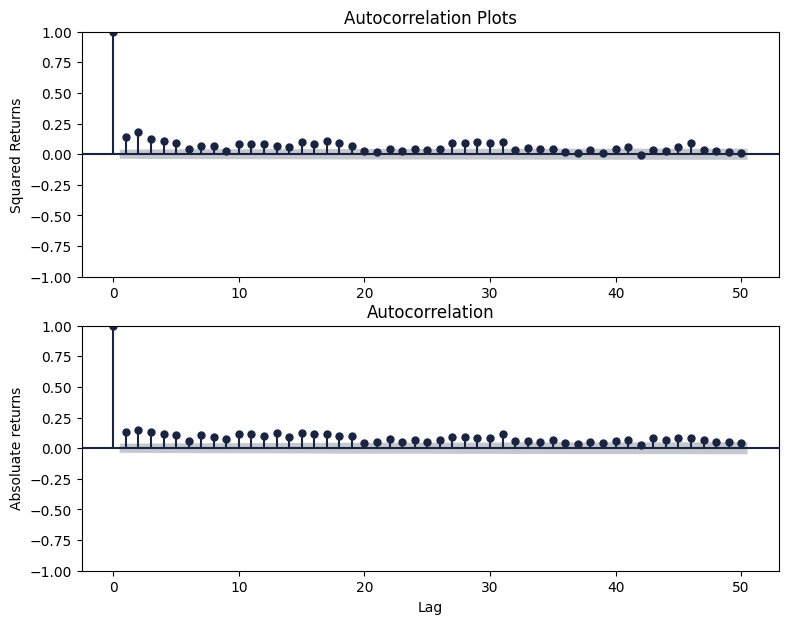

In [ ]:
f, ax = plt.subplots(2,1, figsize = (9,7))

smt.graphics.plot_acf(df2.log_rtn ** 2, lags = N_LAGS,
                      alpha = significance_level,
                      ax = ax[0])

ax[0].set(title = 'Autocorrelation Plots',
          ylabel = 'Squared Returns')

smt.graphics.plot_acf(np.abs(df2.log_rtn), lags = N_LAGS,
                      alpha = significance_level, ax = ax[1])
ax[1].set(ylabel = 'Absoluate returns',
          xlabel = 'Lag')

plt.show()


###**Fact 5 - Leverage effect**

In [ ]:
# Calculate volatility measurs as moving standard deviations
df2['moving_std_252'] = df2[['log_rtn']].rolling(window = 252).std()
df2['moving_std_21'] = df2[['log_rtn']].rolling(window = 21).std()

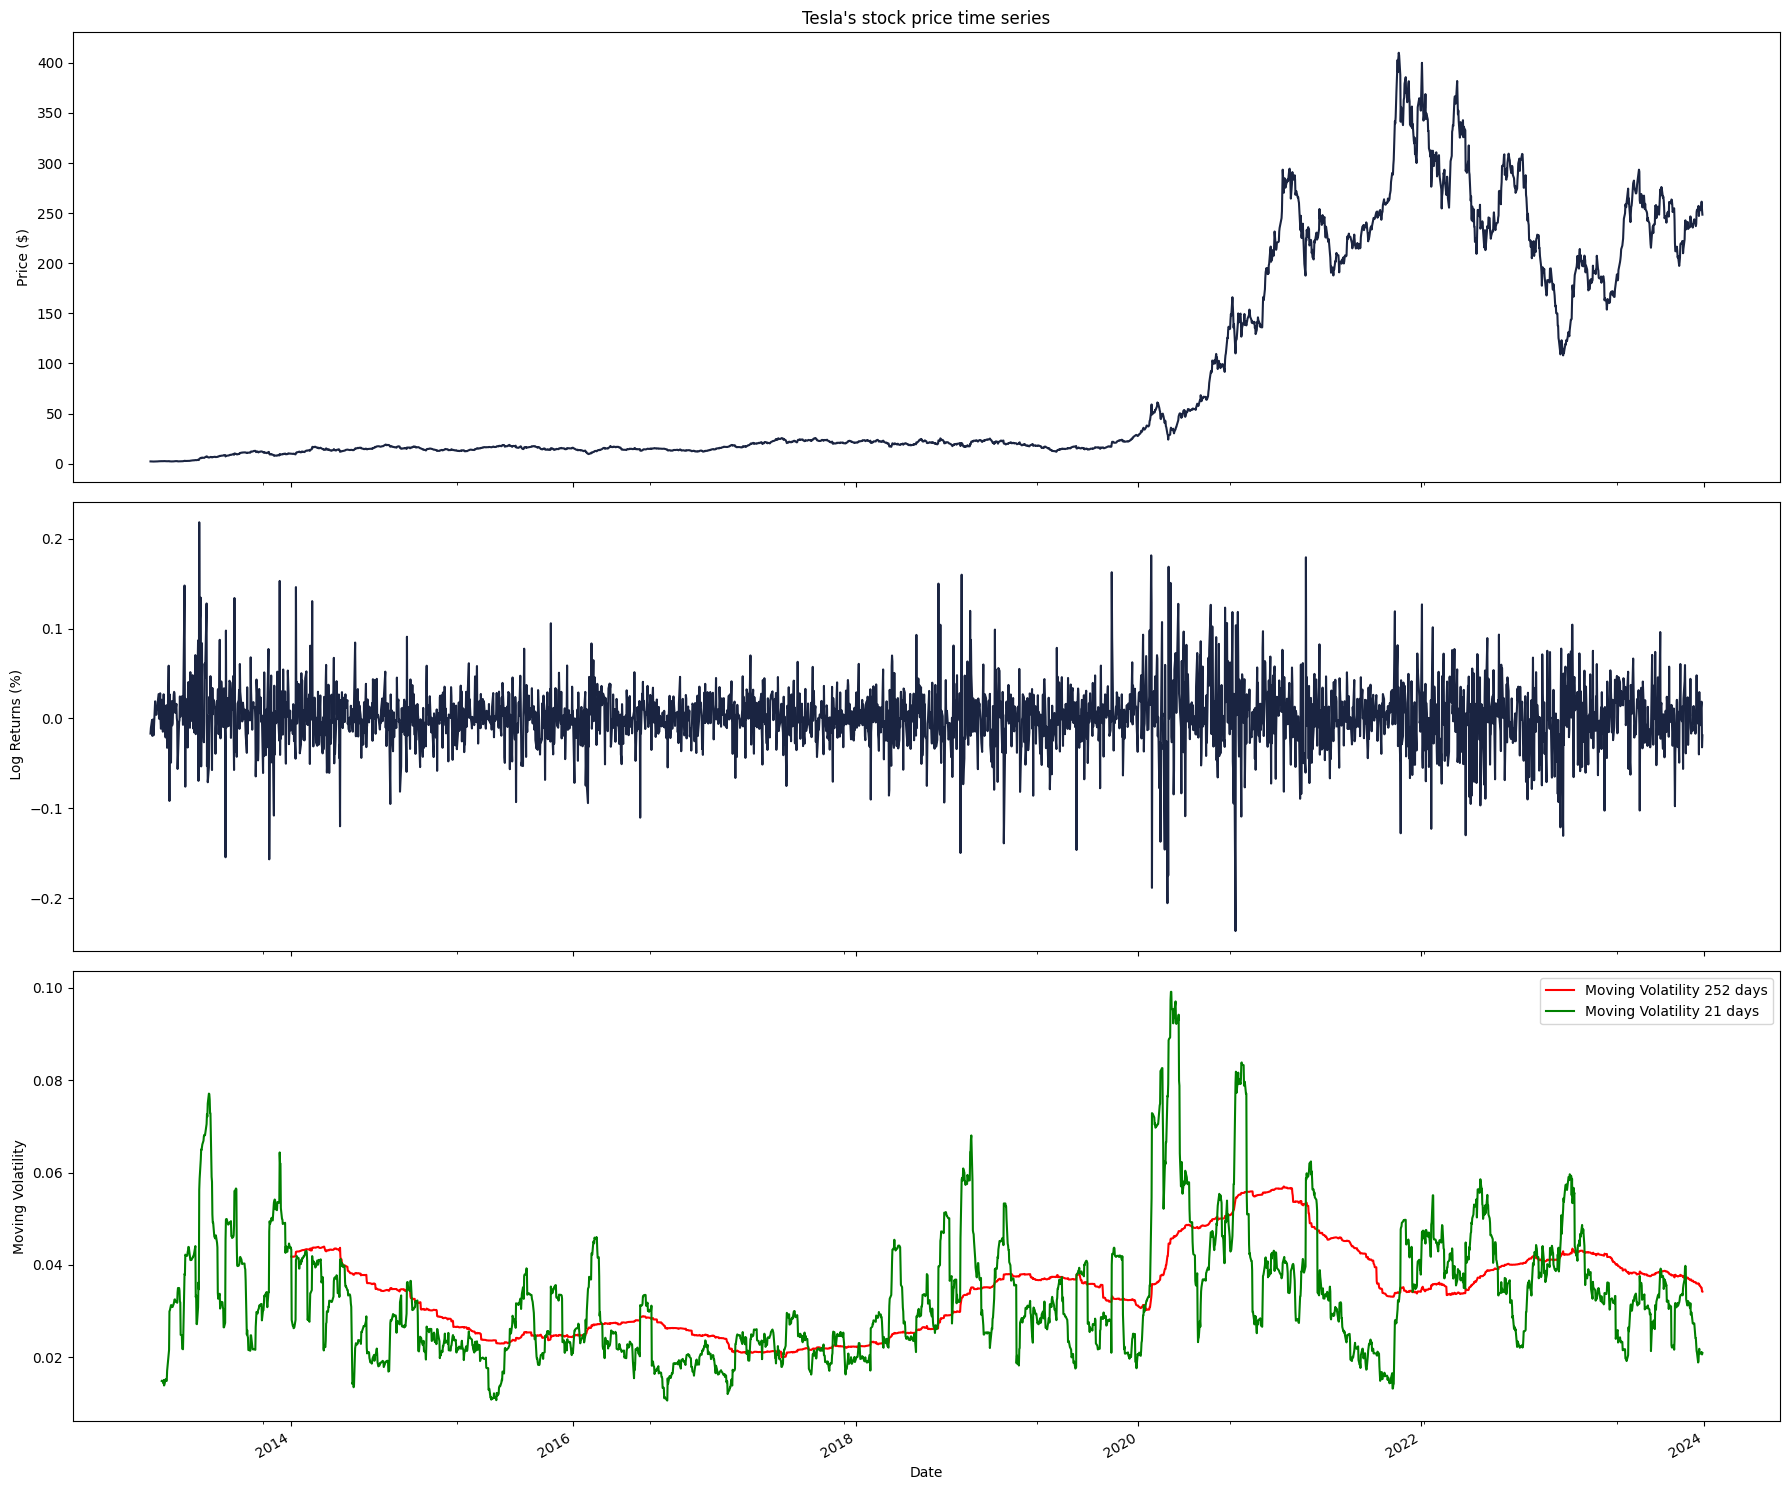

In [ ]:
f, ax = plt.subplots(3,1, figsize = (18,15), sharex = True)

df2.adj_close.plot(ax = ax[0])
ax[0].set(title = "Tesla's stock price time series", ylabel = 'Price ($)')

df2.log_rtn.plot(ax = ax[1])
ax[1].set(ylabel = ' Log Returns (%)')

df2.moving_std_252.plot(ax = ax[2], color = 'r',
                       label = 'Moving Volatility 252 days')

df2.moving_std_21.plot(ax = ax[2], color = 'green',
                      label = 'Moving Volatility 21 days')

ax[2].set(ylabel = 'Moving Volatility',
          xlabel = 'Date')

ax[2].legend()
plt.tight_layout()
plt.show()

# **Charter 3 - Time Series Modeling**

## **Decomposing time series**

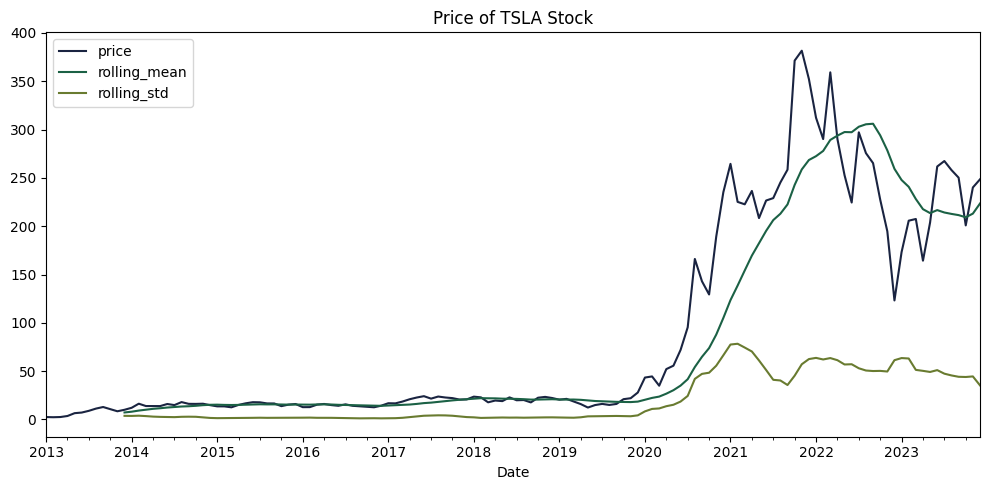

In [ ]:
df3 = df[['Close']]
df3.rename(columns={'Close':'price'}, inplace = True)
df3 = df3.resample('M').last()
#Add rolling mean and standard deviation
window_size = 12
df3['rolling_mean'] = df3.price.rolling(window = 12).mean()
df3['rolling_std'] = df3.price.rolling(window = 12).std()

df3.plot(title='Price of TSLA Stock', figsize = (10,5))

plt.tight_layout()
plt.show()

<Figure size 1000x700 with 0 Axes>

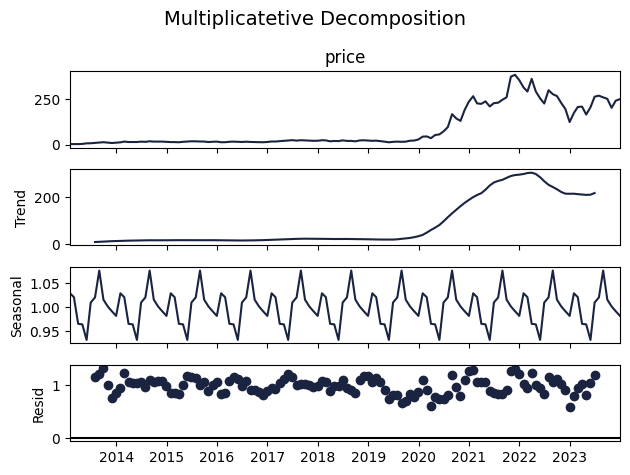

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Carry out seasonal decomposition using the multiplicative model

decomposition_results = seasonal_decompose(df3.price, model = 'multiplicative')

plt.figure(figsize = (10,7))
decomposition_results.plot().suptitle('Multiplicatetive Decomposition', fontsize = 14)

plt.tight_layout()
plt.show()

## **Testing for stationarity in time series**

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity

    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity

    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''

    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [ ]:
adf_test(df3.price)

Test Statistic             -0.675021
p-value                     0.853114
# of Lags Used             13.000000
# of Observations Used    118.000000
Critical Value (1%)        -3.487022
Critical Value (5%)        -2.886363
Critical Value (10%)       -2.580009
dtype: float64

Test Statistic (-0.675021): This value represents the ADF statistic itself. A more negative value indicates stronger rejection of the null hypothesis (presence of a unit root).

p-value (0.853114): This value signifies the probability of observing a test statistic as extreme as -0.675021, assuming the null hypothesis is true. In this case, a high p-value (greater than 0.05) suggests we fail to reject the null hypothesis.

Critical Values: These values represent the thresholds for rejecting the null hypothesis at different significance levels (1%, 5%, and 10%). Since the test statistic is not more negative than any of the critical values, we again fail to reject the null hypothesis.

Interpretation:

Since we fail to reject the null hypothesis, it implies that the price data likely exhibits a random walk behavior. This means the price changes are unpredictable and the series has a constant mean and variance.

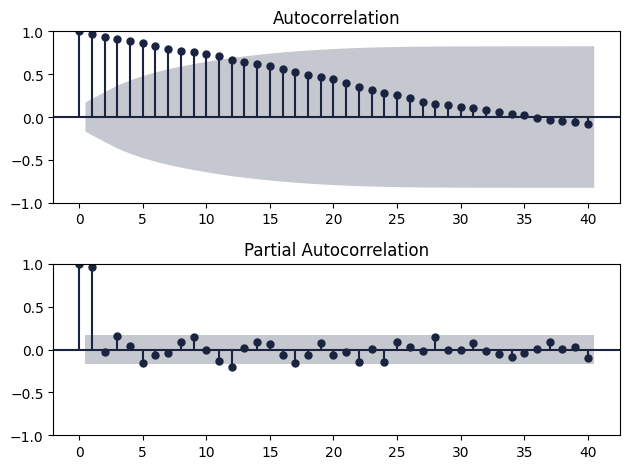

In [ ]:
#generate the ACF/PACF plots
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2,1)

plot_acf(df3.price, ax = ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df3.price, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
plt.show()

The plots you generated are the autocorrelation function (ACF) and partial autocorrelation function (PACF) for your time series data. These plots measure the correlation between a time series and its lagged values, helping to identify patterns and dependencies within the data.

Insights from the plots:

Autocorrelation Function (ACF): The ACF plot shows that the autocorrelations die off slowly for the first few lags, but then become insignificant afterwards. This suggests there might be some short-term dependence in the data, but no significant long-term dependence.

Partial Autocorrelation Function (PACF): The PACF plot shows a single significant spike at lag 1, and then tails off quickly. This indicates that there might be a significant linear dependence between the current value of the time series and its value one lag period before. In other words, there might be a short-term trend in the data.

Combining the results:

By looking at both plots together, we can infer that there might be a short-term trend or seasonality in your price data. The ACF suggests a weak dependence for a few lags, while the PACF isolates the first lag as the most significant contributor to this dependence.

## **Modeling time series with exponential smoothing methods**

In [ ]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 640x480 with 0 Axes>

In [ ]:
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,
                                         SimpleExpSmoothing,
                                         Holt)

In [ ]:
# create the traning/ test split
df4 = df[['adj_close']]
train = df4.index.year<2018
df_train = df4[train]
df_test = df4[~train]

test_length = len(df_test)

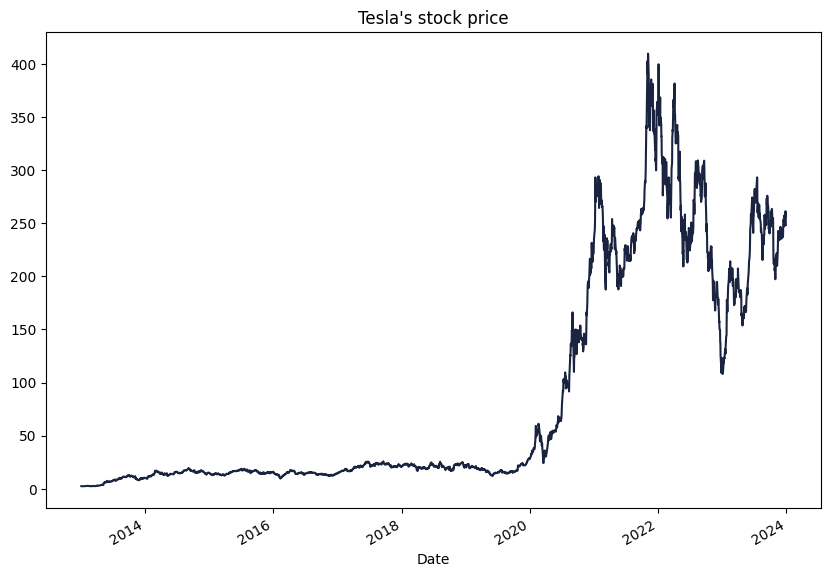

In [ ]:
# plot the prices
plt.figure(figsize=(10,7))
df4['adj_close'].plot(title = "Tesla's stock price")

plt.show()

In [ ]:
# fit 3 simple exponetial smoothing models and create forecasts

ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level = 0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(df_train).fit(smoothing_level = 0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(df_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

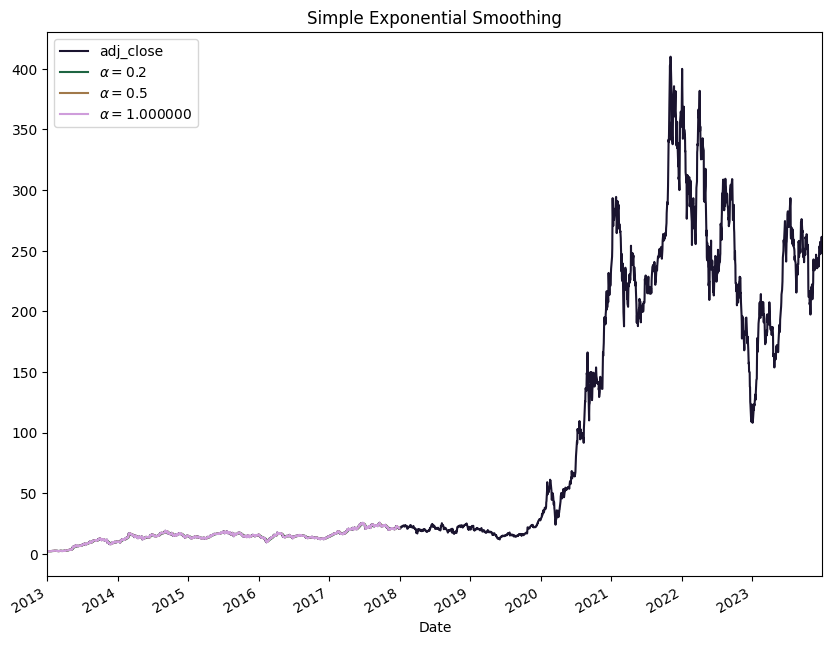

In [ ]:

df4.plot(color = COLORS[0],
         title = 'Simple Exponential Smoothing',
         label = 'Actual',
         legend = True,
         figsize = (10,8))

ses_forecast_1.plot(color = COLORS[1], legend = True,
                    label = r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color = COLORS[1])

ses_forecast_2.plot(color = COLORS[2],  legend = True,
                    label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color = COLORS[2])

ses_forecast_3.plot(color = COLORS[3], legend = True,
                    label = r'$\alpha={0:4f}$'.format(alpha))
ses_3.fittedvalues.plot(color = COLORS[3])

plt.xlim('2013-01-01', '2023-12-31')

plt.show()

The line graph illustrate that the three forecast lines were generated using alpha values of 0.25, 0.5, and 1.0. The forecast line with alpha = 0.25 puts the least weight on past observations and appears to be the most responsive to recent changes in the stock price. The forecast line with alpha = 1.0 puts the most weight on past observations and appears to be the smoothest of the three forecast lines.

Get insight:

- The stock price appears to have increased in the periods of 10 years.
- The forecast lines generated using alpha values of 0.25 and 0.5 appear to be more accurate than the forecast line generated using an alpha value of 1.0.

Overall, the simple exponential smoothing can be a useful technique for forecasting future values in a time series, but it is important to choose an appropriate alpha value and to be aware of the limitations of the technique.

In [ ]:
# Seasonal
seasonal_periods = 12

#Holt-Winter's model with exponential trend
hw_1 =ExponentialSmoothing(df_train,
                           trend = 'mul',
                           seasonal = 'add',
                           seasonal_periods = seasonal_periods).fit()

hw_forecast_1 = hw_1.forecast(test_length)

#Holt-Winter;s model with exponential trend and damping

hw_2 = ExponentialSmoothing(df_train,
                            trend = 'mul',
                            seasonal = 'add',
                            seasonal_periods = seasonal_periods,
                            damped = True).fit()

hw_forecast_2 = hw_2.forecast(test_length)

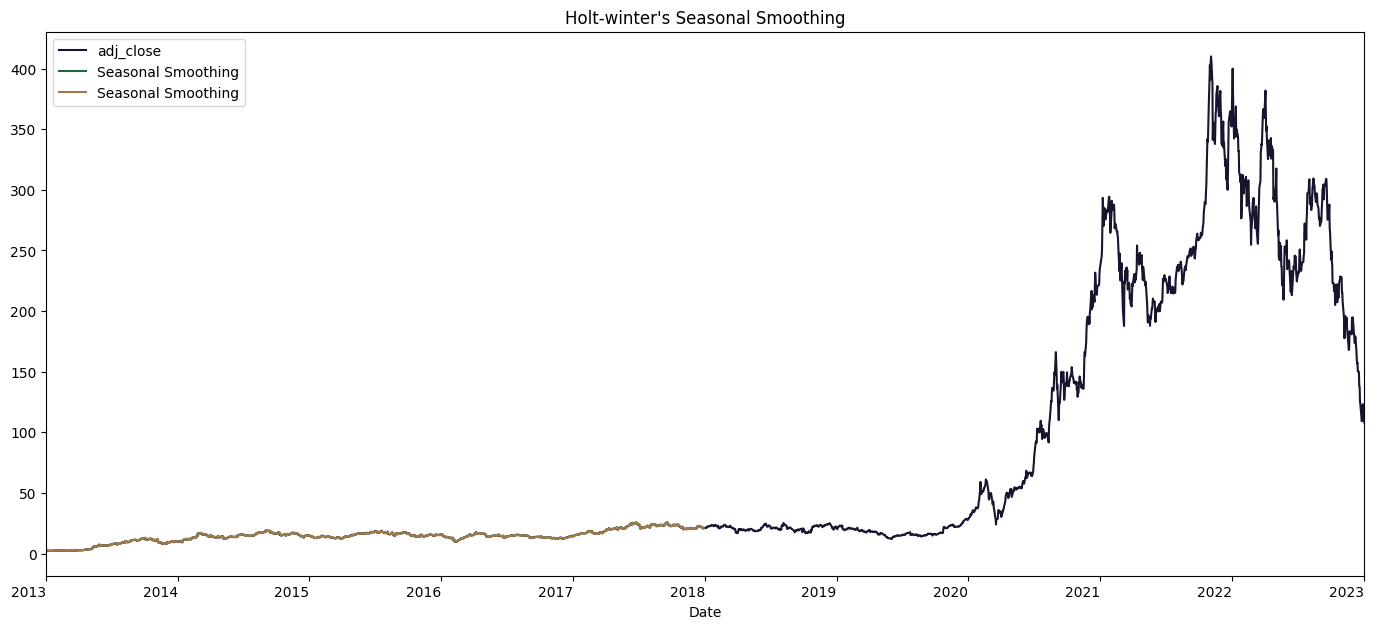

In [ ]:
df4.plot(color = COLORS[0],
         title="Holt-winter's Seasonal Smoothing",
         label = 'Actual',
         legend = True,
         figsize =(17,8))

hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend = True,
                   label = 'Seasonal Smoothing')

#phi = hw_2.model.params['damping_slope']
#plot_label = f'Seasonal Smoothing (damped with r"$\alpha={0:4f}$")'

hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True,
                   label="Seasonal Smoothing")

plt.xlim('2013-01-01','2023-01-01')

plt.show()

## **Modeling time series with ARIMA class models**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs

import pmdarima as pm

In [ ]:
df5 = df[['adj_close']]
df5 =  df5.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close
train = df5.index.year<2018
df_train = df5[train]
df_test = df5[~train]


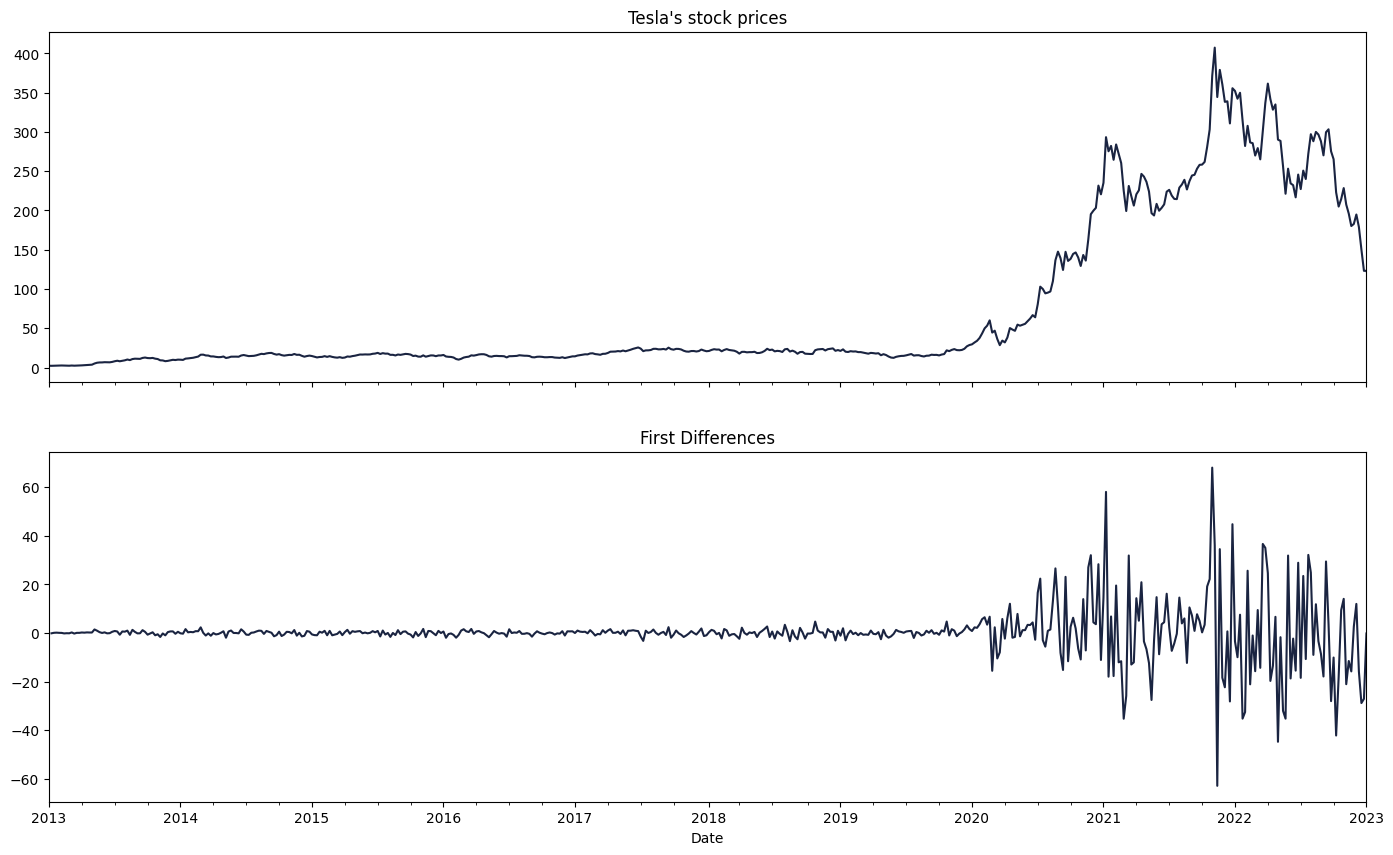

In [ ]:
df_diff = df5.diff().dropna()

fig, ax = plt.subplots(2,1, sharex = True, figsize = (17,10))
df5.plot(title = "Tesla's stock prices", ax = ax[0])
df_diff.plot(ax = ax[1],title ="First Differences")

plt.xlim('2013-01-01','2023-01-01')

plt.show()

- The line graphs illustrate the daily closing price and first differences of Tesla's stock. The first difference is calculated by subtracting the previous day's closing price from the current day's closing price. This essentially shows the change in price over the past day.

Get insight:

- Tesla's stock price has been increasing over time. This is evident from the generally upward trend in the stock price plot.
The stock price has been volatile. The first differences plot also highlights this volatility, with some days showing significant increases or decreases in price.

Overall, this chart suggests that **Tesla's stock is a risky investment**, **but it has the potential for high returns.**



In [ ]:
# ARIMA model and fir it to the data
arima = ARIMA(df_train, order=(2, 1, 1)).fit(df_train)
arima.params = ['param1', 'param2', 'param3']

print(f"arima.params: {arima.params}")
print(f"len(arima.params): {len(arima.params)}")

print(arima.params)

arima.params: ['param1', 'param2', 'param3']
len(arima.params): 3
['param1', 'param2', 'param3']


In [ ]:
auto_arima = pm.auto_arima(df_train,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -323.199
Date:                Mon, 18 Mar 2024   AIC                            648.397
Time:                        03:53:29   BIC                            651.958
Sample:                    01-06-2013   HQIC                           649.829
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7035      0.056     12.645      0.000       0.594       0.813
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 9.42
Prob(Q):                              0.72   Prob(JB):                         0.01
Heteroskedasticity (H):               1.67   Skew:                            -0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1. **Model:**  

The chosen model is SARIMA(0, 1, 0). This means there is no autoregressive term (AR) or seasonal component, but there is one moving average term (MA) of order 1. In other words, ***the forecast for the next time period is simply the previous error term (the difference between the actual value and the predicted value)***


2. **Log Likelihood:**

The log likelihood is -323.199. ***Lower values indicate a worse fit.***

3. **AIC, BIC, HQIC:**

These are all information criteria used to compare models. ***Lower values indicate a better fit.***

4. **Ljung-Box Q-Test and Jarque-Bera Test:**

These are tests for normality of the residuals. The null hypothesis is that the residuals are normally distributed. In this case, ***the p-value for the Ljung-Box Q-Test is 0.72, which is greater than 0.05, so we fail to reject the null hypothesis that there is no serial correlation in the residuals.The p-value for the Jarque-Bera test is 0.01 < 0.05, so we reject the null hypothesis that the residuals are normally distributed. This suggests that the model may not be ideal.***

5. **Heteroskedasticity Test:**

This test checks for constant variance of the residuals.*** The p-value is 0.02< 0.05, so we reject the null hypothesis of homoscedasticity. This implies that the variance of the residuals is not constant.***

Overall, the model fit is not great. There is evidence of non-normality in the residuals and heteroscedasticity.
**=> Try refitting the model with a different specification or using a different time series forecasting approach.**

In [ ]:
auto_arima = pm.auto_arima(df_train,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False,
                           stepwise=False,
                           approximation=False,
                           n_jobs=-1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -322.263
Date:                Mon, 18 Mar 2024   AIC                            648.527
Time:                        03:53:32   BIC                            655.648
Sample:                    01-06-2013   HQIC                           651.390
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0710      0.053      1.335      0.182      -0.033       0.175
sigma2         0.6984      0.055     12.642      0.000       0.590       0.807
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 9.42
Prob(Q):                              0.72   Prob(JB):                         0.01
Heteroskedasticity (H):               1.74   Skew:                            -0.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1. **Model:**

The chosen model is SARIMAX(0, 1, 0). This means there is no autoregressive term (AR) or seasonal component, but there is one moving average term (MA) of order 1, similar to the SARIMA model.


2. **Log Likelihood:**

The log likelihood is -322.263. It is slightly better than the SARIMA model which had a log likelihood of -323.199.


3. **AIC, BIC, HQIC:**

These are all information criteria used to compare models. The AIC is slightly lower than the SARIMA model which had an AIC of 648.397, but the BIC and HQIC are higher.

4. **Ljung-Box Q-Test and Jarque-Bera Test:**

This is the same result as the SARIMA model.


Overall, the SARIMAX model offers a slight improvement in log likelihood over the SARIMA model, but the AIC, BIC and HQIC are not conclusive. **=> Both models suffer from non-normality in the residuals and heteroscedasticity.**

## **Fitting data** ##

 GARCH (Generalized Autoregressive Conditional Heteroscedasticity) model will be used to handle imbalanced this dataset beacause dataset is heteroscedasticity.

In [ ]:
df_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 313 entries, 2018-01-07 to 2023-12-31
Freq: W-SUN
Series name: adj_close
Non-Null Count  Dtype  
--------------  -----  
313 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [ ]:
from arch import arch_model

In [ ]:
#Calculate returns for modeling
returns = 100*df_test.pct_change().dropna()

# Specify the GRACH model
garch = arch_model(returns, p=1, q=1)

#fit the model summary
model_fit = garch.fit(disp = "off")

# print model summary
print(model_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              adj_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1121.02
Distribution:                  Normal   AIC:                           2250.05
Method:            Maximum Likelihood   BIC:                           2265.02
                                        No. Observations:                  312
Date:                Mon, Mar 18 2024   Df Residuals:                      311
Time:                        03:57:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.9387      0.498      1.885  5.947e-02 [-3.74

1. **Sample size:** The model is fit on 312 observations.

2. **Omega:** The omega coefficient is 5.5938, which represents the constant term in the variance equation. It captures the unconditional variance of the errors.

3. **Alpha:** The alpha coefficient is 0.0684. It measures the impact of the squared past error on the current volatility.

4. **Beta:** The beta coefficient is 0.8631. It measures the persistence of volatility. A value of 1 indicates that shocks to volatility have a permanent impact, while a value closer to zero indicates that they are mean-reverting.

**Overall,** the model seems to capture some of the volatility dynamics in the data. The presence of ARCH terms (significant alpha) suggests that past volatility affects future volatility.

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 22.7424
P-value: 0.1208
Distributed: chi2(16)
<class 'numpy.float64'>


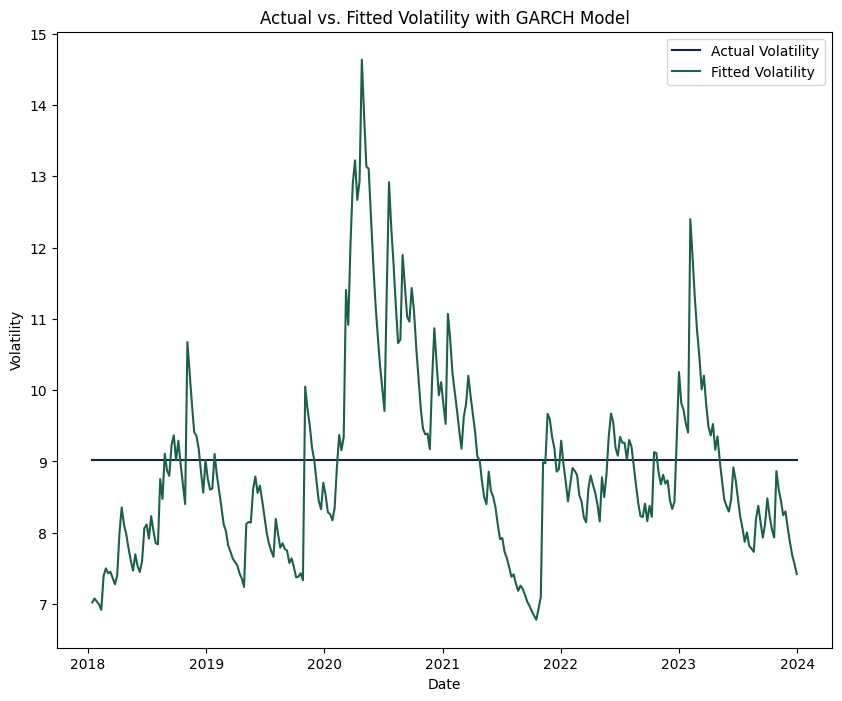

In [ ]:

# Test for conditional heteroscedasticity (ARCH effects)

print(model_fit.arch_lm_test())  # This will print test statistics and p-values

# Visualize actual vs. fitted volatility


# Extract actual and fitted volatilities from the model
fitted_volatility = model_fit.conditional_volatility
actual_volatility = model_fit.resid.std()

# Print the type of actual_volatility
print(type(actual_volatility))

# Convert actual_volatility to a Series object with a DatetimeIndex
actual_volatility = pd.Series(actual_volatility, index=model_fit.resid.index)

# Plot actual and fitted volatility
plt.figure(figsize=(10,8))
plt.plot(actual_volatility.index, actual_volatility, label="Actual Volatility")
plt.plot(fitted_volatility.index, fitted_volatility, label="Fitted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Actual vs. Fitted Volatility with GARCH Model")
plt.legend()
plt.show()

**Jarque-Bera Normality Test:**

The p-value is 0.0000 < 0.05. This suggests that we can reject the null hypothesis that the residuals are normally distributed. In other words, the residuals are not normally distributed.


Engle's LM ARCH Test:

The LM statistic is 22.54 with a p-value of 0.0002. A significant p-value (less than 0.05) rejects the null hypothesis of no ARCH effects. This means there is evidence of remaining ARCH effects in the residuals.


**Actual vs Fitted Volatility Plot give information that:**

It appears that the fitted volatility generally follows the trend of the actual volatility . However, there are some deviations, particularly towards the end of the series where the actual volatility seems more volatile than the fitted volatility.


**Overall Insights:**

The diagnostics suggest that the ***ARCH model might not be ideal for your data.*** The non-normal residuals and the presence of ARCH effects indicate that ***the model may not have captured all the volatility dynamics in your data.***

In [ ]:
# Handle imbalance data with GARCH model with t-distributed

return_1 = 100*df_test.pct_change().dropna()
garch_t = arch_model(return_1, vol='GARCH', p=1,q=1, dist='studentsT')

model_fit_t = garch_t.fit(disp='off')
print(model_fit_t.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    adj_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1117.51
Distribution:      Standardized Student's t   AIC:                           2245.03
Method:                  Maximum Likelihood   BIC:                           2263.74
                                              No. Observations:                  312
Date:                      Mon, Mar 18 2024   Df Residuals:                      311
Time:                              04:30:25   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 22.6642
P-value: 0.1230
Distributed: chi2(16)
<class 'numpy.float64'>


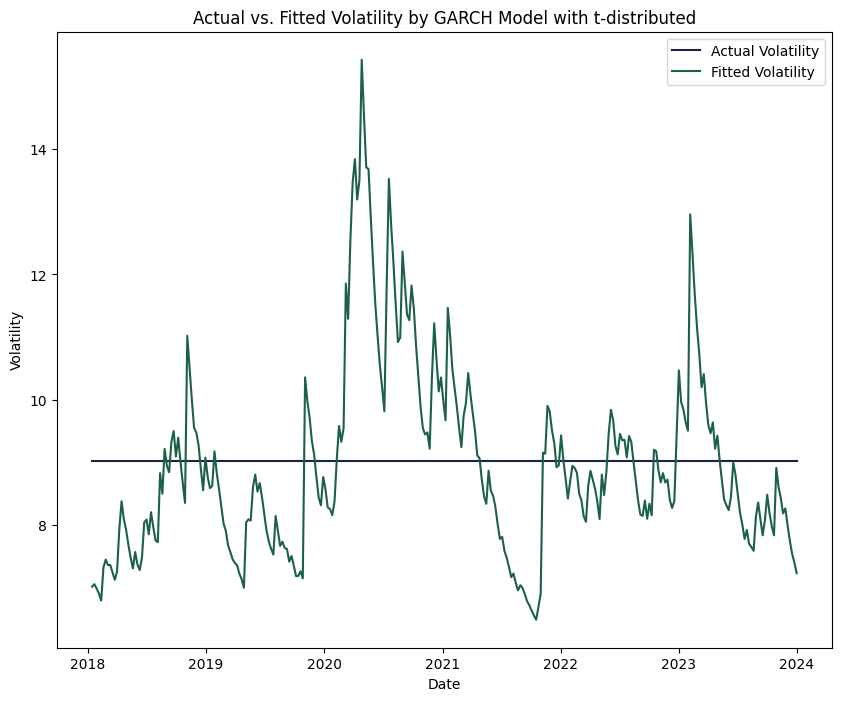

In [ ]:
print(model_fit_t.arch_lm_test())

# Visualize actual vs. fitted volatility

# Extract actual and fitted volatilities from the model
fitted_volatility_t = model_fit_t.conditional_volatility
actual_volatility_t = model_fit_t.resid.std()

# Print the type of actual_volatility
print(type(actual_volatility_t))

# Convert actual_volatility to a Series object with a DatetimeIndex
actual_volatility_t = pd.Series(actual_volatility, index=model_fit_t.resid.index)

# Plot actual and fitted volatility
plt.figure(figsize=(10,8))
plt.plot(actual_volatility_t.index, actual_volatility_t, label="Actual Volatility")
plt.plot(fitted_volatility_t.index, fitted_volatility_t, label="Fitted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Actual vs. Fitted Volatility by GARCH Model with t-distributed")
plt.legend()
plt.show()

**Overall**, the GARCH model with t-distributed errors seems to be a better fit for your data compared to the regular GARCH model with normal errors. There is a slight improvement in the log-likelihood, AIC, and BIC values.  The t-distribution assumption might have helped capture the non-normality observed in the residuals from the previous model.

In [ ]:
# define the number of steps to forecast volatility
h = 10 # forecast volatility for the next 10 periods

#geberate volatility forecasts
volatility_forecast = model_fit_t.forecast(horizon=h)

# investigate the volatility_forecast object
print(volatility_forecast)

# access the forecast volatility using the fitted values attribute
#print(volatility_forecast.forecast_volatility)

In [ ]:
# Check the type of the volatility_forecast object
print(type(volatility_forecast))

# Check if the forecast_dates attribute is present in the volatility_forecast object
if hasattr(volatility_forecast, 'forecast_dates'):
    # 1. Forecast dates (optional):
    forecast_dates = volatility_forecast.forecast_dates # This gives the dates for the forecasts

    # 2. Forecasted conditional volatilities:
    forecasted_volatility = volatility_forecast.conditional_volatility  # These are the actual volatility forecasts

    # Print the results in a DataFrame (optional):
    results_df = pd.DataFrame({"Date": forecast_dates, "Volatility Forecast": forecasted_volatility})
    print(results_df)
else:
    print("The forecast_dates attribute is not present in the volatility_forecast object.")

<class 'arch.univariate.base.ARCHModelForecast'>
The forecast_dates attribute is not present in the volatility_forecast object.


In [ ]:
print(f"Length of auto_arima_pred: {len(auto_arima_pred)}")

print(f"Length of return_1: {len(return_1)}")

Length of auto_arima_pred: 2
Length of return_1: 312


## **Build model**

In [ ]:
train = df[['adj_close']]
return_train = 100*train[['adj_close']].pct_change().dropna()

In [ ]:
return_train

,adj_close
Date,
2013-01-03,-1.668533
2013-01-04,-1.064151
2013-01-07,-0.174416
2013-01-08,-1.921964
2013-01-09,-0.118735
...,...
2023-12-22,-0.770140
2023-12-26,1.611623
2023-12-27,1.882241


In [ ]:
model = ARIMA(return_train, order=(2, 1, 1))
model_fit = model.fit()

In [ ]:
n_periods = len(return_train)

forecast = model_fit.forecast(steps=n_periods)

In [ ]:

# Mean Squared Error (MSE)
mse = mean_squared_error(return_train, forecast)
print("Mean Squared Error:", mse)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(return_train, forecast, squared=False)
print("Root Mean Squared Error:", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(return_train, forecast)
print("Mean Absolute Error:", mae)

Mean Squared Error: 12.855007324585186
Root Mean Squared Error: 3.5853880298490965
Mean Absolute Error: 2.4700884109916545


In [ ]:
print(type(return_train))
print(type(forecast))
print(len(return_train))
print(len(forecast))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
2767
2767


In [ ]:
# Create a Pandas DataFrame (optional)
data = pd.DataFrame({"Actual": return_train, "Forecast": forecast})

# Plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(data["Actual"], label="Actual Values")
plt.plot(data["Forecast"], label="Forecasts")
plt.title("Actual vs. Forecast")
plt.xlabel("Date/Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

ValueError: Data must be 1-dimensional

## **Test with actual values**

In [ ]:
# Download the data
actual = yf.download('TSLA',
                 start = '2024-01-01',
                 end = '2024-03-17',
                 progress = False)
actual.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,250.080002,251.250000,244.410004,248.419998,248.419998,104654200
2024-01-03,244.979996,245.679993,236.320007,238.449997,238.449997,121082600
2024-01-04,239.250000,242.699997,237.729996,237.929993,237.929993,102629300
2024-01-05,236.860001,240.119995,234.899994,237.490005,237.490005,92379400
2024-01-08,236.139999,241.250000,235.300003,240.449997,240.449997,85166600


In [ ]:
actual_values = actual[['Adj Close']]
#actual_values = actual_values.resample('W').mean()
actual_values.head()

,Adj Close
Date,
2024-01-02,248.419998
2024-01-03,238.449997
2024-01-04,237.929993
2024-01-05,237.490005
2024-01-08,240.449997


In [ ]:
actual_values = 100*actual_values['Adj Close'].pct_change().dropna()

In [ ]:
print(len(actual_values))
print(len(forecast))

51
51


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming your actual values are in 'actual_values' and forecasts are in 'forecast_values'

# Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast)
print("Mean Squared Error:", mse)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual_values, forecast, squared=False)
print("Root Mean Squared Error:", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast)
print("Mean Absolute Error:", mae)

Mean Squared Error: 9.243623055732117
Root Mean Squared Error: 3.0403327212218265
Mean Absolute Error: 2.1129586965935454


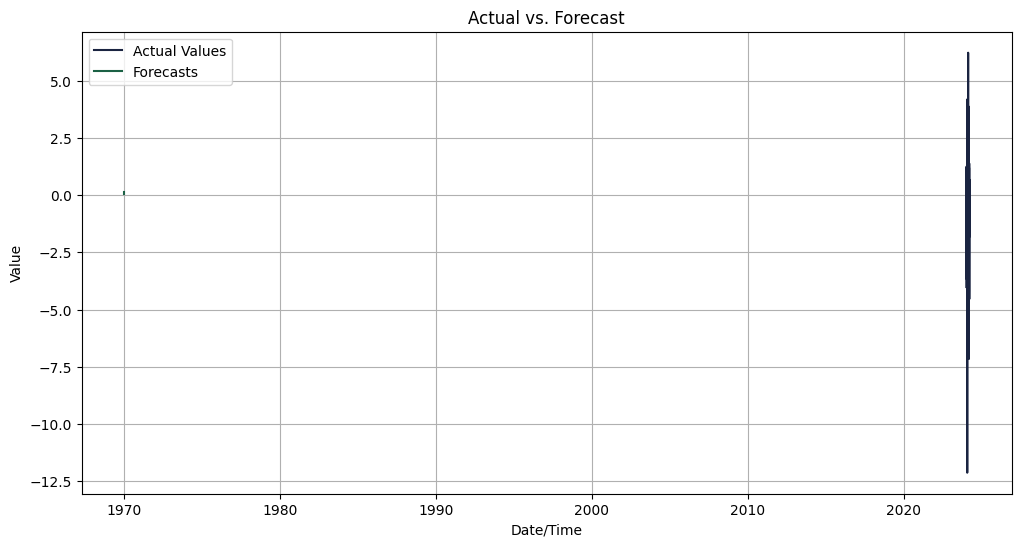

In [ ]:
# Create a Pandas DataFrame (optional)
data = pd.DataFrame({"Actual": actual_values, "Forecast": forecast})

# Plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(data["Actual"], label="Actual Values")
plt.plot(data["Forecast"], label="Forecasts")
plt.title("Actual vs. Forecast")
plt.xlabel("Date/Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()